In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer
import math
%matplotlib inline

In [2]:
run 'clean_data.py'

In [3]:
monthly_df = df[df['depth']<=20]

In [4]:
df = df.drop(df.columns[[1,2]], axis=1)

In [5]:
df.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
41,1984,80.7333,12.8533,37.0,-0.8118,347.7
42,1984,80.7333,12.8533,77.0,1.5336,315.0
43,1984,80.7333,12.8533,116.0,2.3164,317.6
44,1984,80.7333,12.8533,156.0,2.8303,314.1


In [6]:
surface = df[df['depth']<=20]

In [7]:
surface.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
58,1984,80.9050,18.5883,5.0,2.3114,386.9
59,1984,80.9050,18.5883,18.0,1.2787,382.5
66,1984,81.0517,17.6683,6.0,1.7416,372.3
82,1984,81.1967,16.7933,4.0,-0.7188,398.3


# EDA

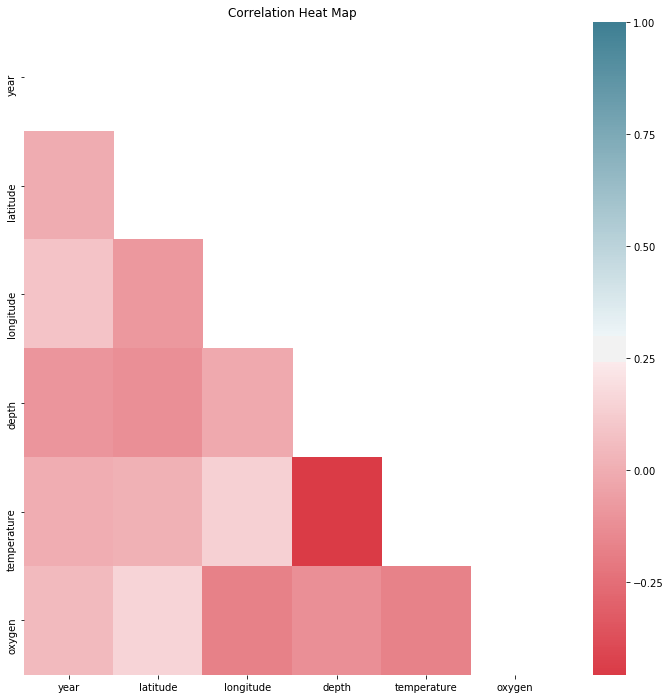

In [8]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Correlation Heat Map")

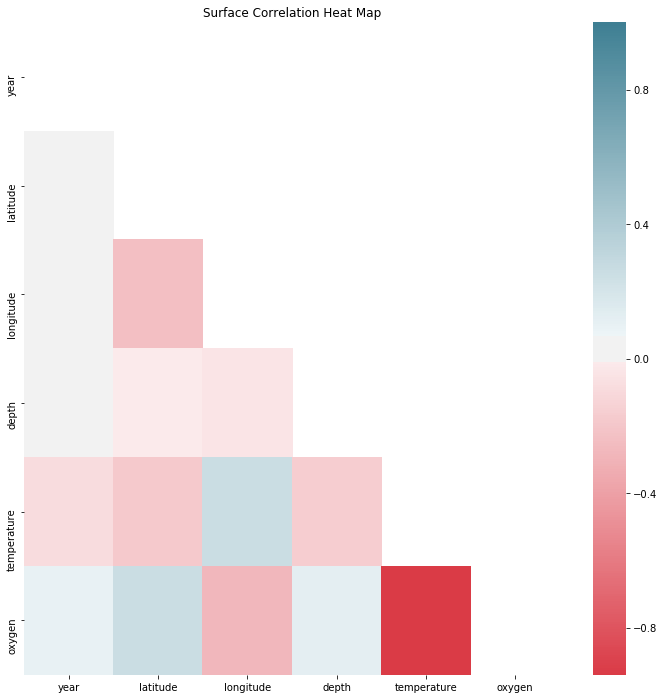

In [9]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(surface.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(surface.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

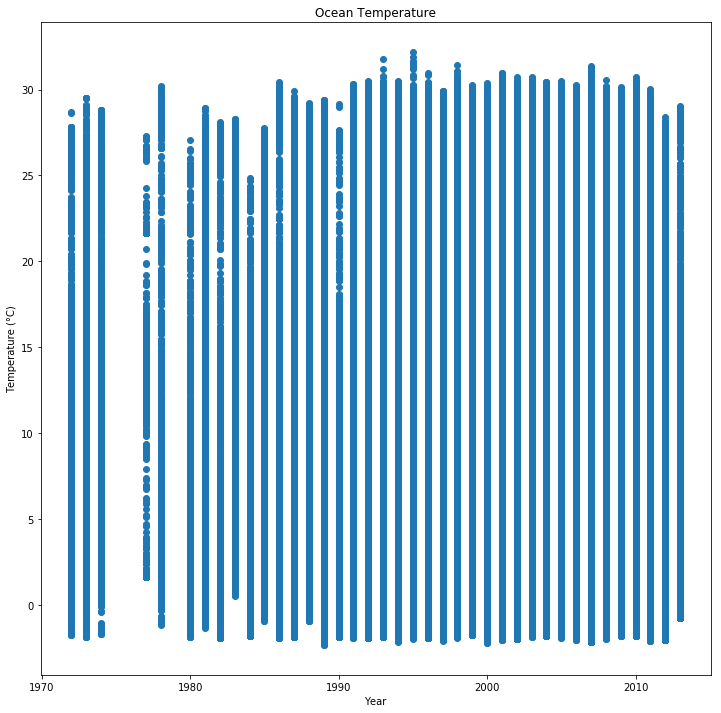

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Ocean Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(df['year'], df['temperature'])

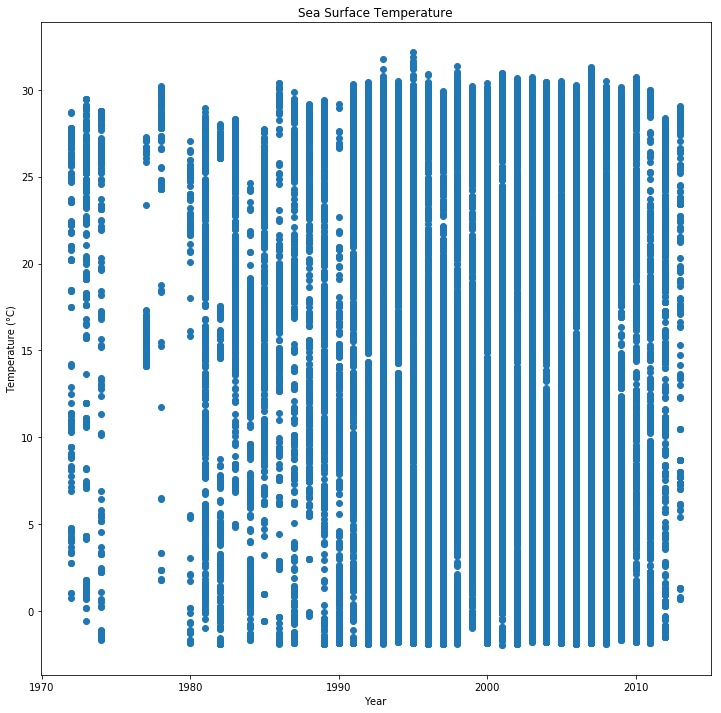

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(surface['year'], surface['temperature'])

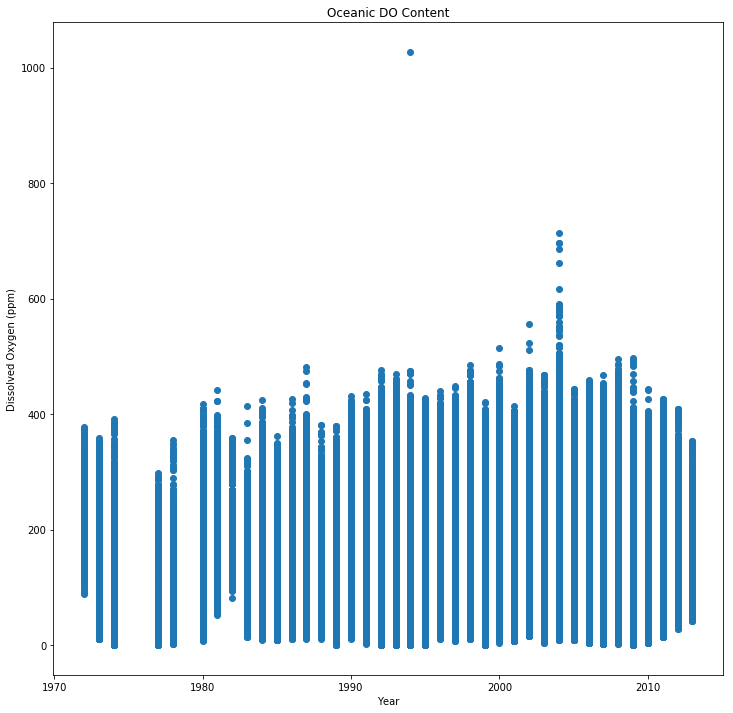

In [8]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Oceanic DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(df['year'], df['oxygen'])

### What is that outlier?

In [13]:
df[df['oxygen']>800]

,year,latitude,longitude,depth,temperature,oxygen
164928,1994,50.0058,-144.971,3345.0,1.5171,1026.9


### Let's keep it!

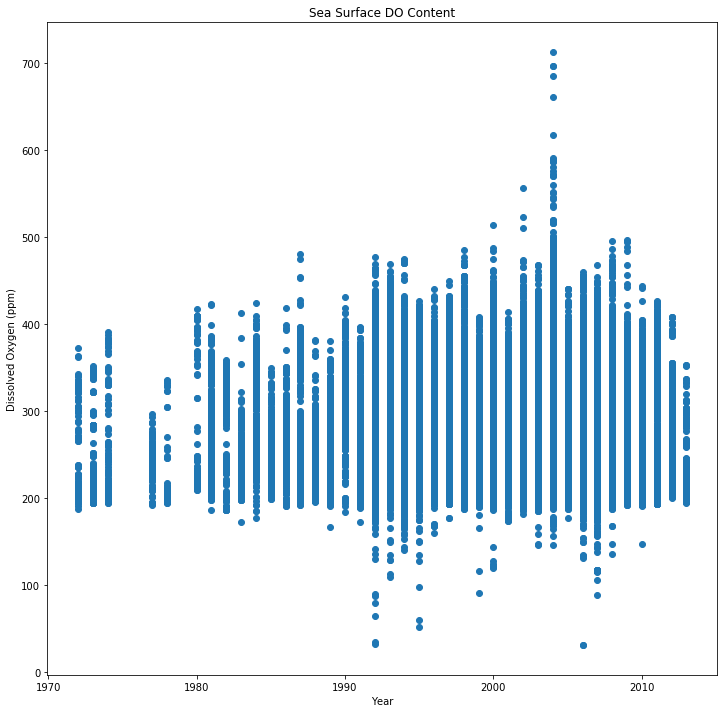

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(surface['year'], surface['oxygen'])

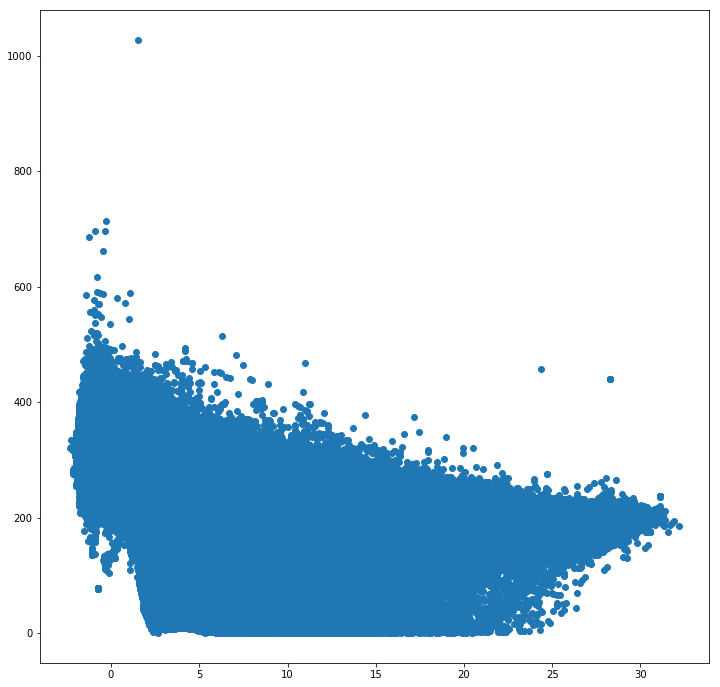

In [15]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.scatter(df['temperature'], df['oxygen'])

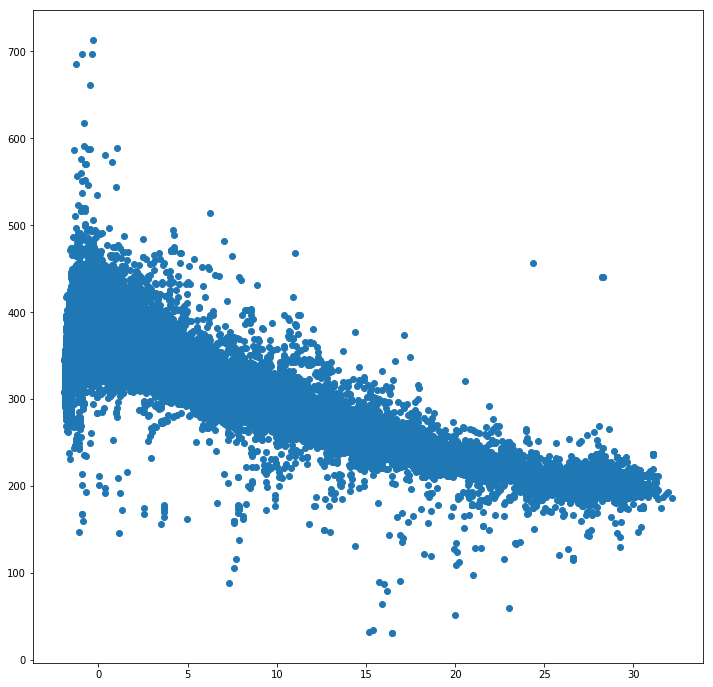

In [9]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(surface['temperature'], surface['oxygen'])

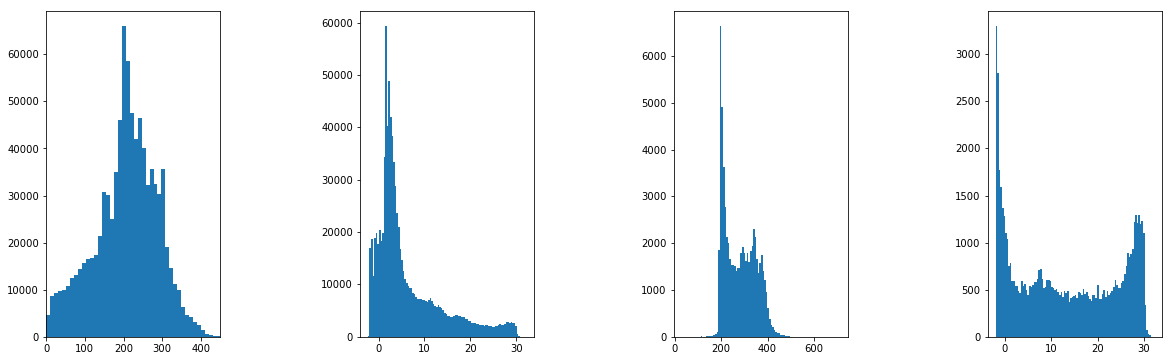

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(141)
ax.set_xlim(0, 450)
ax.hist(df['oxygen'], bins=100)

ax2 = fig.add_subplot(142)
ax2.hist(df['temperature'], bins=100)

ax3 = fig.add_subplot(143)
ax3.hist(surface['oxygen'], bins=100)

ax4 = fig.add_subplot(144)
ax4.hist(surface['temperature'], bins=100)
fig.subplots_adjust(wspace=0.8)

### Scatter Matrix

In [ ]:
_ = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [ ]:
_ = pd.plotting.scatter_matrix(surface, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [10]:
surftemp = surface[['year','temperature']]

In [11]:
surftempbyyr = surftemp.groupby(['year'], as_index=False).mean()

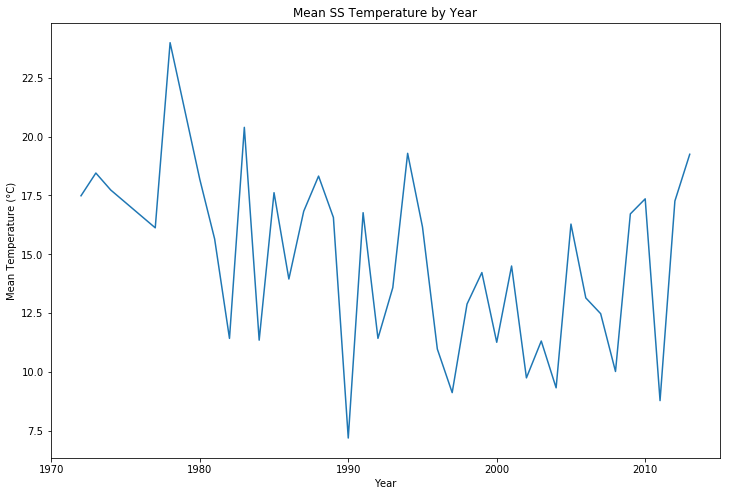

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Mean SS Temperature by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.plot(surftempbyyr['year'], surftempbyyr['temperature'])

## Exploring Summer

In [17]:
northern = monthly_df[monthly_df['latitude']>23.5]
southern = monthly_df[monthly_df['latitude']<-23.5]

In [18]:
northern_summer = northern.query('6 <= month <= 8')

In [19]:
southern_summer = southern[(southern['month']==12) | (southern['month']==1) | (southern['month']==2)]

In [20]:
summer = pd.concat([northern_summer, southern_summer])

In [21]:
summer_means = summer.groupby(['year'], as_index=False).mean()

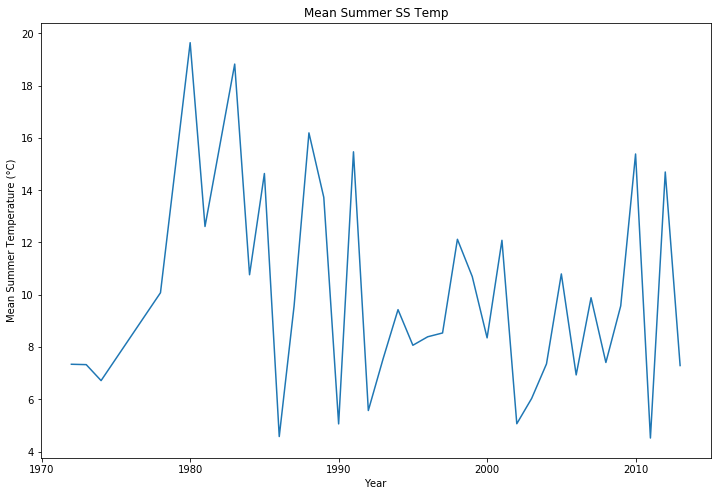

In [16]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Mean Summer SS Temp')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Summer Temperature (°C)')
ax.plot(summer_means['year'], summer_means['temperature'])

In [22]:
southern_winter = southern.query('6 <= month <= 8')

In [23]:
northern_winter = northern[(northern['month']==12) | (northern['month']==1) | (northern['month']==2)]

In [24]:
winter = pd.concat([northern_winter,southern_winter])

In [25]:
winter_means = winter.groupby(['year'], as_index=False).mean()

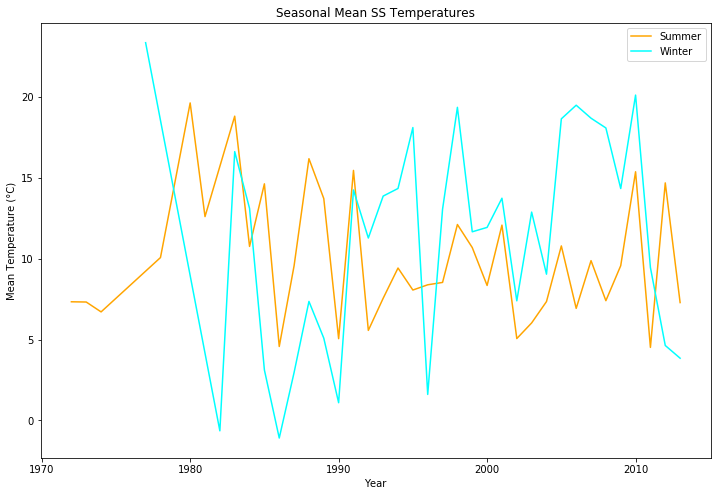

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Seasonal Mean SS Temperatures')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.plot(summer_means['year'], summer_means['temperature'], color='orange', label = 'Summer')
ax.plot(winter_means['year'], winter_means['temperature'], color='cyan', label = 'Winter')
ax.legend()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Seasonal Mean SS Temperatures')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.plot(summer_means['year'], summer_means['temperature'], color='r', label = 'Summer')
ax.plot(winter_means['year'], winter_means['temperature'], color='b', label = 'Winter')
ax.legend()

### Welch's t-test: 1990s vs 2000s

In [26]:
winter_90s = winter.query('1990 <= year <= 1999')
winter_00s = winter.query('2000 <= year <= 2009')

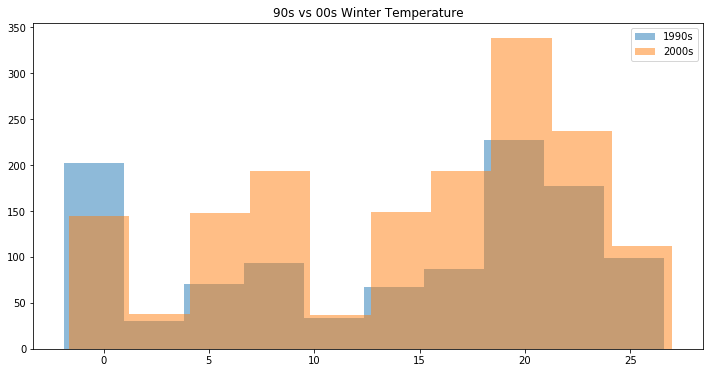

In [27]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(winter_90s['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(winter_00s['temperature'], alpha=0.5, label='2000s')
ax.legend()

In [28]:
stats.ttest_ind(winter_90s['temperature'],winter_00s['temperature'], equal_var=False)

Ttest_indResult(statistic=-3.47156741405691, pvalue=0.0005277833871404403)

In [29]:
summer_90s = summer.query('1990 <= year <= 1999')
summer_00s = summer.query('2000 <= year <= 2009')

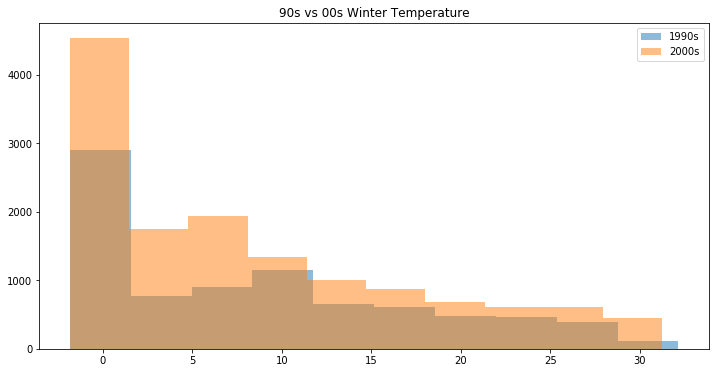

In [30]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(summer_90s['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(summer_00s['temperature'], alpha=0.5, label='2000s')
ax.legend()

In [31]:
stats.ttest_ind(summer_90s['temperature'],summer_00s['temperature'], equal_var=False)

Ttest_indResult(statistic=3.526090916159732, pvalue=0.0004228044642918308)

In [32]:
summer_90s['temperature'].mean()

8.621515504798028

In [33]:
summer_00s['temperature'].mean()

8.180991073446299

In [34]:
winter_90s['temperature'].mean()

13.30678130755063

In [35]:
winter_00s['temperature'].mean()

14.496017410433707

#### Temperature by decade is not normally distributed, but the t-test can still be valid with such large sample sizes. Below, we calculate p-values with the nonparametric Mann-Whitney U test.

In [36]:
stats.mannwhitneyu(winter_90s['temperature'],winter_00s['temperature'])

MannwhitneyuResult(statistic=812943.5, pvalue=0.004720990266716179)

In [37]:
stats.mannwhitneyu(summer_90s['temperature'],summer_00s['temperature'])

MannwhitneyuResult(statistic=56894925.5, pvalue=0.0015660627454797394)

## Predictive Modeling

In [162]:
df2 = pd.read_csv('data/master2.csv')
df2 = df2[df2['depth']<=20]

In [158]:
df2 = df2.drop(['ccl4','sf6', 'he', 'month', 'day'], axis=1)

In [159]:
df2 = df2.replace([-9999, -999, -8888, -888, -7777, -777, -6666, -666],np.NaN)

In [160]:
df2.rename(columns={'talk': 'alkalinity'}, inplace=True)

In [161]:
df2['alkalinity'].describe()

count    321393.000000
mean       2327.290342
std          63.748681
min          65.000000
25%        2298.000000
50%        2326.100000
75%        2358.410000
max        2647.300000
Name: alkalinity, dtype: float64

In [109]:
def get_percentage_missing(series):
   ''' Calculates percentage of NaN values in DataFrame
   :param series: Pandas DataFrame object
   :return: float
   '''
   num = series.isnull().sum()
   den = len(series)
   return round(num/den, 2)# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values);

In [119]:
get_percentage_missing(df2)

year           0.0
latitude       0.0
longitude      0.0
depth          0.0
temperature    0.0
salinity       0.0
oxygen         0.0
nitrate        0.0
nitrite        0.0
silicate       0.0
phosphate      0.0
alkalinity     0.0
phts25p0       0.0
cfc11          0.0
cfc12          0.0
cfc113         0.0
dtype: float64

In [118]:
cols_to_keep = ['temperature', 'salinity', 'oxygen', 'nitrate', 'nitrite', 'silicate', 'phosphate', 'alkalinity', 'phts25p0', 'cfc11', 'cfc12', 'cfc113']
for column in cols_to_keep:
    if get_percentage_missing(df2[f'{column}']) <= 0.96:
        df2[f'{column}'].fillna((df2[f'{column}'].mean()), inplace=True)

Text(0.5,1,'Surface Correlation Heat Map')

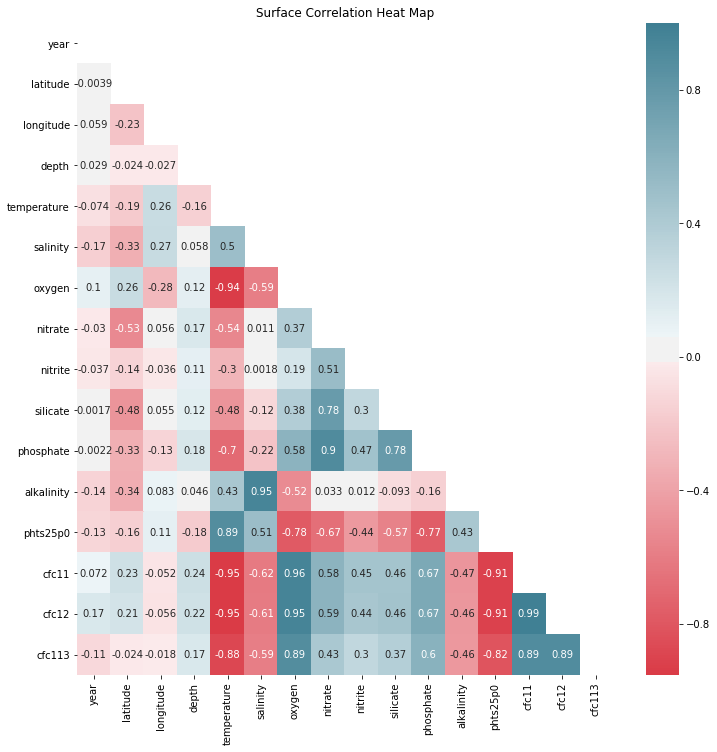

In [68]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df2.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

In [69]:
columns = ['nitrate', 'nitrite', 'cfc113', 'latitude', 'alkalinity']

Text(0.5,1,'Surface Correlation Heat Map')

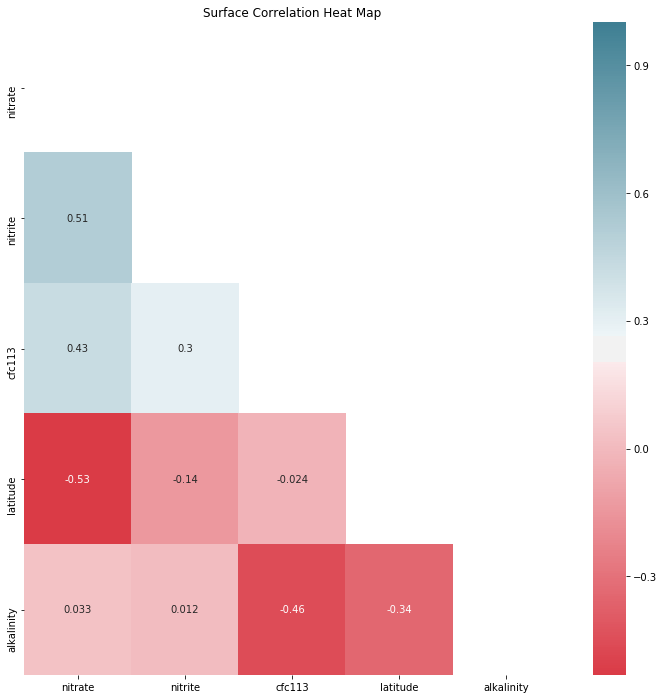

In [70]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df2[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df2[columns].corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

In [166]:
X = df2['temperature']
y = df2['alkalinity']
X = X.reshape(-1,1)
y = y.reshape(-1,1)

KeyError: 'alkalinity'

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [144]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
y

array([[2269.88523529],
       [2269.88523529],
       [2269.88523529],
       ...,
       [2269.88523529],
       [2269.88523529],
       [2269.88523529]])

RMSE: 70.44864463397589


Text(0,0.5,'Predicted Alkalinity')

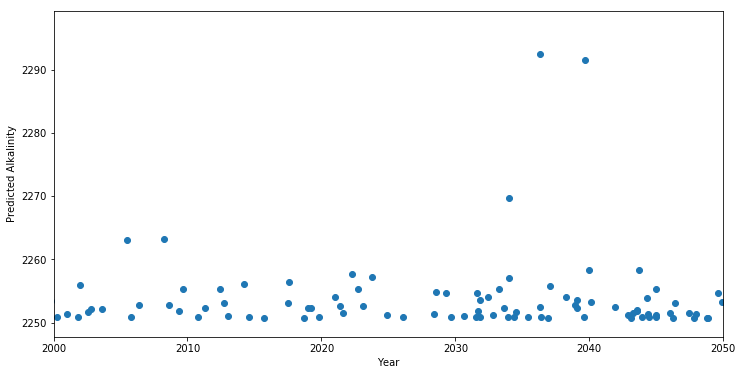

In [164]:
predicted_X_test = linear.predict(X_test)

print(f'RMSE: {math.sqrt(mean_squared_error(y_test, predicted_X_test))}')

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(y_test, predicted_X_test)
ax.set_xlabel("Year")
ax.set_xlim(2000, 2050)
ax.set_ylabel("Predicted Alkalinity")

In [165]:
predicted_X_test

array([[2281.36108391],
       [2292.18887154],
       [2257.29369616],
       ...,
       [2252.09023638],
       [2253.91427527],
       [2271.67806852]])